##Regression Task

In [ ]:
pip install pytorch-tabnet optuna

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

###Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from pytorch_tabnet.tab_model import TabNetRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Dropout, Add, LayerNormalization, MultiHeadAttention, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor


###Feature Mapping


In [ ]:
# Mapping dictionary between the two datasets
feature_mapping = {
    'AGE_sess': 'Age',
    'EDSS 000': 'EDSS_Visual',
    'EDSS 001': 'EDSS_Brainstem',
    'EDSS 002': 'EDSS_Pyramidal',
    'EDSS 003': 'EDSS_Cerebellar',
    'EDSS 004': 'EDSS_Sensory',
    'EDSS 005': 'EDSS_Bowel',
    'EDSS 006': 'EDSS_Mental',
    'EDSS 007': 'EDSS_Walking',
    'EDSS TOT 2': 'EDSS_TOT',
    'MOCA TOT': 'MoCa',
    'SDMT TOT': 'SDMT',
    'MFIS 001': 'MFIS_1',
    'MFIS 002': 'MFIS_2',
    'MFIS 003': 'MFIS_3',
    'MFIS 004': 'MFIS_4',
    'MFIS 005': 'MFIS_5',
    'MFIS 006': 'MFIS_6',
    'MFIS 007': 'MFIS_7',
    'MFIS 008': 'MFIS_8',
    'MFIS 009': 'MFIS_9',
    'MFIS 010': 'MFIS_10',
    'MFIS 011': 'MFIS_11',
    'MFIS 012': 'MFIS_12',
    'MFIS 013': 'MFIS_13',
    'MFIS 014': 'MFIS_14',
    'MFIS 015': 'MFIS_15',
    'MFIS 016': 'MFIS_16',
    'MFIS 017': 'MFIS_17',
    'MFIS 018': 'MFIS_18',
    'MFIS 019': 'MFIS_19',
    'MFIS 020': 'MFIS_20',
    'MFIS 021': 'MFIS_21',
    'MFIS TOT': 'MFIS TOT',
    'OAB-Q001': 'OAB-Q_1',
    'OAB-Q002': 'OAB-Q_2',
    'OAB-Q003': 'OAB-Q_3',
    'OAB-Q004': 'OAB-Q_4',
    'OAB-Q005': 'OAB-Q_5',
    'OAB-Q006': 'OAB-Q_6',
    'OAB-Q007': 'OAB-Q_7',
    'OAB-Q008': 'OAB-Q_8',
    'OAB-QTOT': 'OAB-Q TOT',
    'RELAPS': 'Last relapse',
    'GEND_F': 'Gender_F',
    'GEND_M': 'Gender_M'
}

###Function to Create Time Series Data

In [ ]:
def create_time_series_data(data, target, date_column, period=3):
    data = data.copy()
    data['Date'] = pd.to_datetime(data[date_column])
    data = data.sort_values(by=['ID', 'Date'])
    X, y = [], []
    unique_ids = data['ID'].unique()

    for uid in unique_ids:
        patient_data = data[data['ID'] == uid]
        patient_data = patient_data.set_index('Date').resample('4M').ffill().reset_index()
        features = patient_data.drop(columns=['ID', target, 'Date'])
        target_values = patient_data[target]

        for i in range(len(features) - period):
            X.append(features.iloc[i:i + period].values)
            y.append(target_values.iloc[i + period])

    return np.array(X), np.array(y)


###Data Loading and Preprocessing

In [ ]:
# Load the PROMOPROMS dataset
promoproms_file_path = '/content/drive/MyDrive/datasets/PROMOPROMS_FINAL.csv'
promoproms_data = pd.read_csv(promoproms_file_path)
promoproms_data['Date'] = pd.to_datetime(promoproms_data['Date'])

# Impute missing values
missing_columns = promoproms_data.columns[promoproms_data.isnull().any()]
for column in missing_columns:
    if promoproms_data[column].dtype == 'object':
        promoproms_data[column].fillna(promoproms_data[column].mode()[0], inplace=True)
    else:
        promoproms_data[column].fillna(promoproms_data[column].mean(), inplace=True)

# Sort data by patient ID and date
promoproms_data = promoproms_data.sort_values(by=['ID', 'Date'])

# Rename PROMOPROMS features according to the mapping
promoproms_data.rename(columns=feature_mapping, inplace=True)

# Select only the mapped features
selected_features_promoproms = list(feature_mapping.values())

# Filter PROMOPROMS dataset to include only the mapped features
X_promoproms = promoproms_data[selected_features_promoproms + ['ID', 'Date']].copy()

# Load ALAMEDA dataset
ALAMEDA_file_path = '/content/drive/MyDrive/datasets/Updated_ALAMEDA_FISM_final_with_numerical_IDs.csv'
ALAMEDA_data = pd.read_csv(ALAMEDA_file_path)

ALAMEDA_data['Timepoint'] = pd.to_datetime(ALAMEDA_data['Timepoint'])

# One-hot encode the Gender column
encoder = OneHotEncoder(sparse_output=False)
gender_encoded = encoder.fit_transform(ALAMEDA_data[['Gender']])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['Gender_F', 'Gender_M'])

# Drop the original Gender column and replace with the encoded one
ALAMEDA_data = pd.concat([ALAMEDA_data.drop(columns=['Gender']), gender_encoded_df], axis=1)

# Apply the feature_mapping to ALAMEDA data
mapped_features_alameda = list(feature_mapping.values())

# Identify and log which columns are missing in the ALAMEDA dataset
missing_columns = [col for col in mapped_features_alameda if col not in ALAMEDA_data.columns]
if missing_columns:
    print(f"Warning: The following columns are missing in the ALAMEDA dataset: {missing_columns}")

# Filter ALAMEDA dataset to include only the mapped features that exist
available_features_alameda = [feature for feature in mapped_features_alameda if feature in ALAMEDA_data.columns]
ALAMEDA_data = ALAMEDA_data[available_features_alameda + ['ID', 'Timepoint']]

# Rename the 'Timepoint' column to 'Date' for consistency
ALAMEDA_data.rename(columns={'Timepoint': 'Date'}, inplace=True)

# Combine the datasets
combined_data = pd.concat([promoproms_data, ALAMEDA_data], ignore_index=True)

# Select relevant features and target
selected_features = list(feature_mapping.values()) + ['ID', 'Date']
X = combined_data[selected_features]
y = combined_data['EDSS_TOT']

# Prepare time series data
X_ts, y_ts = create_time_series_data(X, 'EDSS_TOT', 'Date', period=3)

###Define 5-Fold Cross Validation and Training Models (TabNet, TFT, TCN, TST, MLP, GBR)

In [ ]:
# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}
learning_curves = {}

for fold, (train_index, test_index) in enumerate(kf.split(X_ts)):
    print(f"Fold {fold+1}")

    X_train, X_test = X_ts[train_index], X_ts[test_index]
    y_train, y_test = y_ts[train_index], y_ts[test_index]

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Flatten data for MLP and Gradient Boosting
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Reshape y_train and y_test for TabNet
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # TabNet
    tabnet_model = TabNetRegressor(
        n_d=15,
        n_a=15,
        n_steps=5,
        gamma=1.3,
        lambda_sparse=1e-3,
        optimizer_params=dict(lr=2e-2),
        n_independent=2,
        n_shared=2,
        seed=42,
    )
    tabnet_model.fit(
        X_train=X_train_flat,
        y_train=y_train,
        eval_set=[(X_test_flat, y_test)],
        eval_name=['val'],
        eval_metric=['mse'],
        max_epochs=100,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    tabnet_learning_curve = tabnet_model.history
    learning_curves[f'TabNet_Fold_{fold+1}'] = tabnet_learning_curve
    y_pred_tabnet = tabnet_model.predict(X_test_flat)
    tabnet_mse = mean_squared_error(y_test, y_pred_tabnet)
    tabnet_rmse = np.sqrt(tabnet_mse)
    tabnet_r2 = r2_score(y_test, y_pred_tabnet)
    print(f'TabNet - MSE: {tabnet_mse}, RMSE: {tabnet_rmse}, R2 Score: {tabnet_r2}')

    # TFT
    tft_model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])
    tft_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history_tft = tft_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[es])
    learning_curves[f'TFT_Fold_{fold+1}'] = history_tft.history
    y_pred_tft = tft_model.predict(X_test)
    tft_mse = mean_squared_error(y_test, y_pred_tft)
    tft_rmse = np.sqrt(tft_mse)
    tft_r2 = r2_score(y_test, y_pred_tft)
    print(f'TFT - MSE: {tft_mse}, RMSE: {tft_rmse}, R2 Score: {tft_r2}')

    # TCN
    def build_enhanced_tcn_model(input_shape):
        inputs = Input(shape=input_shape)

        x = Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu', dilation_rate=1)(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        x = Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu', dilation_rate=2)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        # Residual connection
        residual = Conv1D(filters=64, kernel_size=1, padding='causal', dilation_rate=4)(inputs)
        x = Add()([x, residual])

        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        return model

    input_shape = (X_train.shape[1], X_train.shape[2])
    enhanced_tcn_model = build_enhanced_tcn_model(input_shape)
    history_tcn = enhanced_tcn_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[es])
    learning_curves[f'TCN_Fold_{fold+1}'] = history_tcn.history
    y_pred_tcn = enhanced_tcn_model.predict(X_test)
    tcn_mse = mean_squared_error(y_test, y_pred_tcn)
    tcn_rmse = np.sqrt(tcn_mse)
    tcn_r2 = r2_score(y_test, y_pred_tcn)
    print(f"Enhanced TCN - MSE: {tcn_mse}, RMSE: {tcn_rmse}, R²: {tcn_r2}")

    # TST
    def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
        x = LayerNormalization(epsilon=1e-6)(inputs)
        x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = Dropout(dropout)(x)
        res = Add()([x, inputs])
        x = LayerNormalization(epsilon=1e-6)(res)
        x = Dense(ff_dim, activation="relu")(x)
        x = Dropout(dropout)(x)
        x = Dense(inputs.shape[-1])(x)
        return Add()([x, res])

    def build_tst_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
        inputs = Input(shape=input_shape)
        x = inputs
        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Flatten()(x)
        for dim in mlp_units:
            x = Dense(dim, activation="relu")(x)
            x = Dropout(mlp_dropout)(x)
        outputs = Dense(1)(x)
        return Model(inputs, outputs)

    tst_model = build_tst_model(
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=64,  # Increased ff_dim for more complex representation
        num_transformer_blocks=4,
        mlp_units=[128, 64],  # Added another MLP layer
        dropout=0.1,
        mlp_dropout=0.1,
    )
    tst_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history_tst = tst_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[es])
    learning_curves[f'TST_Fold_{fold+1}'] = history_tst.history
    y_pred_tst = tst_model.predict(X_test)
    tst_mse = mean_squared_error(y_test, y_pred_tst)
    tst_rmse = np.sqrt(tst_mse)
    tst_r2 = r2_score(y_test, y_pred_tst)
    print(f"TST - MSE: {tst_mse}, RMSE: {tst_rmse}, R²: {tst_r2}")

    # MLP Regressor
    mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
    mlp_model.fit(X_train_flat, y_train.ravel())
    y_pred_mlp = mlp_model.predict(X_test_flat)
    mlp_mse = mean_squared_error(y_test, y_pred_mlp)
    mlp_rmse = np.sqrt(mlp_mse)
    mlp_r2 = r2_score(y_test, y_pred_mlp)
    print(f"MLP Regressor - MSE: {mlp_mse}, RMSE: {mlp_rmse}, R²: {mlp_r2}")

    # Gradient Boosting Regressor
    gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr_model.fit(X_train_flat, y_train.ravel())
    y_pred_gbr = gbr_model.predict(X_test_flat)
    gbr_mse = mean_squared_error(y_test, y_pred_gbr)
    gbr_rmse = np.sqrt(gbr_mse)
    gbr_r2 = r2_score(y_test, y_pred_gbr)
    print(f"Gradient Boosting Regressor - MSE: {gbr_mse}, RMSE: {gbr_rmse}, R²: {gbr_r2}")

    # Store results for each fold
    results[f'Fold {fold+1}'] = {
        'TabNet': (tabnet_mse, tabnet_rmse, tabnet_r2),
        'TFT': (tft_mse, tft_rmse, tft_r2),
        'TCN': (tcn_mse, tcn_rmse, tcn_r2),
        'TST': (tst_mse, tst_rmse, tst_r2),
        'MLP': (mlp_mse, mlp_rmse, mlp_r2),
        'GBR': (gbr_mse, gbr_rmse, gbr_r2)
    }

Fold 1
epoch 0  | loss: 4.95613 | val_mse: 2.08593 |  0:00:00s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 4.02591 | val_mse: 2.0852  |  0:00:00s
epoch 2  | loss: 3.32976 | val_mse: 1.93135 |  0:00:00s
epoch 3  | loss: 3.89603 | val_mse: 2.06592 |  0:00:00s
epoch 4  | loss: 3.3706  | val_mse: 1.91837 |  0:00:00s
epoch 5  | loss: 3.19987 | val_mse: 1.43196 |  0:00:00s
epoch 6  | loss: 2.22975 | val_mse: 1.59315 |  0:00:01s
epoch 7  | loss: 2.0732  | val_mse: 1.70999 |  0:00:01s
epoch 8  | loss: 2.17461 | val_mse: 1.43582 |  0:00:01s
epoch 9  | loss: 1.93666 | val_mse: 1.19234 |  0:00:01s
epoch 10 | loss: 1.91524 | val_mse: 1.68768 |  0:00:01s
epoch 11 | loss: 1.70986 | val_mse: 1.95567 |  0:00:01s
epoch 12 | loss: 1.53455 | val_mse: 1.63387 |  0:00:01s
epoch 13 | loss: 1.72067 | val_mse: 1.47473 |  0:00:02s
epoch 14 | loss: 1.97636 | val_mse: 1.2561  |  0:00:02s
epoch 15 | loss: 1.56147 | val_mse: 1.41999 |  0:00:02s
epoch 16 | loss: 1.71487 | val_mse: 1.29045 |  0:00:02s
epoch 17 | loss: 1.56166 | val_mse: 1.33301 |  0:00:02s
epoch 18 | loss: 1.25354 | val_mse: 0.9794  |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


TabNet - MSE: 0.396600614234573, RMSE: 0.6297623474252593, R2 Score: 0.7278065910839133
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 1.5089 - mae: 0.9396 - val_loss: 0.8277 - val_mae: 0.7225
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6968 - mae: 0.6991 - val_loss: 0.4731 - val_mae: 0.5834
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4509 - mae: 0.5453 - val_loss: 0.3824 - val_mae: 0.4961
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3816 - mae: 0.4937 - val_loss: 0.3567 - val_mae: 0.4658
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3303 - mae: 0.4416 - val_loss: 0.3259 - val_mae: 0.4462
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2923 - mae: 0.4029 - val_loss: 0.3273 - val_mae: 0.4382
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2756 - mae: 0.3926 - val_loss: 0.3132 - val_mae: 0.4158
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2540 - mae: 0.3826 - val

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 3.55641 | val_mse: 1.83424 |  0:00:00s
epoch 2  | loss: 2.73257 | val_mse: 2.34387 |  0:00:00s
epoch 3  | loss: 2.91263 | val_mse: 1.57862 |  0:00:00s
epoch 4  | loss: 2.43402 | val_mse: 2.84648 |  0:00:00s
epoch 5  | loss: 2.57508 | val_mse: 2.68497 |  0:00:00s
epoch 6  | loss: 2.00503 | val_mse: 2.41429 |  0:00:01s
epoch 7  | loss: 1.8606  | val_mse: 1.9921  |  0:00:01s
epoch 8  | loss: 1.73135 | val_mse: 2.51903 |  0:00:01s
epoch 9  | loss: 1.66402 | val_mse: 1.97985 |  0:00:01s
epoch 10 | loss: 1.69752 | val_mse: 1.56686 |  0:00:01s
epoch 11 | loss: 1.71407 | val_mse: 1.54494 |  0:00:01s
epoch 12 | loss: 1.36285 | val_mse: 1.79383 |  0:00:01s
epoch 13 | loss: 1.48776 | val_mse: 1.18622 |  0:00:02s
epoch 14 | loss: 1.61276 | val_mse: 1.61019 |  0:00:02s
epoch 15 | loss: 1.8833  | val_mse: 1.4411  |  0:00:02s
epoch 16 | loss: 1.42234 | val_mse: 1.30932 |  0:00:02s
epoch 17 | loss: 1.47879 | val_mse: 3.8044  |  0:00:02s
epoch 18 | loss: 1.35654 | val_mse: 4.10819 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.3321 - mae: 0.8865 - val_loss: 1.0576 - val_mae: 0.8602
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7489 - mae: 0.6930 - val_loss: 0.6104 - val_mae: 0.6422
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5058 - mae: 0.5837 - val_loss: 0.4856 - val_mae: 0.5496
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4230 - mae: 0.5324 - val_loss: 0.3930 - val_mae: 0.4805
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3249 - mae: 0.4551 - val_loss: 0.3585 - val_mae: 0.4354
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3081 - mae: 0.4318 - val_loss: 0.3637 - val_mae: 0.4399
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3056 - mae: 0.4205 - val_loss: 0.3346 - val_mae: 0.4086
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2519 - mae: 0.3699 - val_loss: 0.3332 - val_mae: 0.3970
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 4.04441 | val_mse: 3.88836 |  0:00:00s
epoch 2  | loss: 2.73979 | val_mse: 1.63866 |  0:00:00s
epoch 3  | loss: 2.80046 | val_mse: 2.71657 |  0:00:00s
epoch 4  | loss: 2.58476 | val_mse: 1.43638 |  0:00:00s
epoch 5  | loss: 2.33612 | val_mse: 1.51299 |  0:00:00s
epoch 6  | loss: 1.86271 | val_mse: 1.18541 |  0:00:01s
epoch 7  | loss: 1.89367 | val_mse: 1.25006 |  0:00:01s
epoch 8  | loss: 1.95366 | val_mse: 1.18774 |  0:00:01s
epoch 9  | loss: 1.89815 | val_mse: 1.01254 |  0:00:01s
epoch 10 | loss: 1.75347 | val_mse: 1.01444 |  0:00:02s
epoch 11 | loss: 1.72551 | val_mse: 1.21462 |  0:00:02s
epoch 12 | loss: 1.85373 | val_mse: 1.17198 |  0:00:02s
epoch 13 | loss: 1.54374 | val_mse: 1.26896 |  0:00:02s
epoch 14 | loss: 1.52683 | val_mse: 1.03494 |  0:00:02s
epoch 15 | loss: 1.62808 | val_mse: 1.03865 |  0:00:03s
epoch 16 | loss: 1.59806 | val_mse: 0.99305 |  0:00:03s
epoch 17 | loss: 1.19174 | val_mse: 1.01723 |  0:00:03s
epoch 18 | loss: 1.26582 | val_mse: 0.90487 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 1.5623 - mae: 0.9371 - val_loss: 0.7770 - val_mae: 0.7037
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7381 - mae: 0.6959 - val_loss: 0.5497 - val_mae: 0.6046
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4694 - mae: 0.5616 - val_loss: 0.4324 - val_mae: 0.5388
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3983 - mae: 0.5019 - val_loss: 0.3670 - val_mae: 0.4896
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3086 - mae: 0.4350 - val_loss: 0.3287 - val_mae: 0.4529
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3329 - mae: 0.4246 - val_loss: 0.3112 - val_mae: 0.4463
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2878 - mae: 0.4005 - val_loss: 0.3010 - val_mae: 0.4233
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2436 - mae: 0.3565 - val_loss: 0.2968 - val_mae: 0.4256
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2459 - 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.77717 | val_mse: 7.3231  |  0:00:00s
epoch 1  | loss: 3.22907 | val_mse: 3.14419 |  0:00:00s
epoch 2  | loss: 3.16429 | val_mse: 2.33798 |  0:00:00s
epoch 3  | loss: 3.48005 | val_mse: 2.04638 |  0:00:00s
epoch 4  | loss: 2.2957  | val_mse: 1.65688 |  0:00:01s
epoch 5  | loss: 1.84468 | val_mse: 1.60194 |  0:00:01s
epoch 6  | loss: 1.85307 | val_mse: 1.57821 |  0:00:01s
epoch 7  | loss: 1.62253 | val_mse: 1.65555 |  0:00:01s
epoch 8  | loss: 1.95716 | val_mse: 1.23296 |  0:00:01s
epoch 9  | loss: 1.71744 | val_mse: 1.20305 |  0:00:02s
epoch 10 | loss: 1.48428 | val_mse: 1.33457 |  0:00:02s
epoch 11 | loss: 1.49987 | val_mse: 1.06494 |  0:00:02s
epoch 12 | loss: 1.57158 | val_mse: 0.90223 |  0:00:02s
epoch 13 | loss: 1.56644 | val_mse: 1.02525 |  0:00:03s
epoch 14 | loss: 1.53713 | val_mse: 1.08125 |  0:00:03s
epoch 15 | loss: 1.45854 | val_mse: 1.15198 |  0:00:03s
epoch 16 | loss: 1.35995 | val_mse: 1.09865 |  0:00:03s
epoch 17 | loss: 1.3338  | val_mse: 1.02764 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.5775 - mae: 0.9337 - val_loss: 0.7611 - val_mae: 0.7286
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7865 - mae: 0.7306 - val_loss: 0.6109 - val_mae: 0.6249
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4696 - mae: 0.5522 - val_loss: 0.4535 - val_mae: 0.5438
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3506 - mae: 0.4673 - val_loss: 0.3794 - val_mae: 0.4873
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3520 - mae: 0.4463 - val_loss: 0.3494 - val_mae: 0.4498
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2666 - mae: 0.4022 - val_loss: 0.3249 - val_mae: 0.4258
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2593 - mae: 0.3874 - val_loss: 0.3195 - val_mae: 0.4138
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2665 - mae: 0.3784 - val_loss: 0.3159 - val_mae: 0.4110
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2741 -

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 3.26042 | val_mse: 2.19634 |  0:00:00s
epoch 2  | loss: 4.94129 | val_mse: 2.09585 |  0:00:00s
epoch 3  | loss: 4.27476 | val_mse: 1.92212 |  0:00:00s
epoch 4  | loss: 2.91967 | val_mse: 2.07207 |  0:00:00s
epoch 5  | loss: 2.2681  | val_mse: 1.36613 |  0:00:00s
epoch 6  | loss: 2.03663 | val_mse: 1.29106 |  0:00:01s
epoch 7  | loss: 2.5077  | val_mse: 1.21502 |  0:00:01s
epoch 8  | loss: 1.71773 | val_mse: 1.33914 |  0:00:01s
epoch 9  | loss: 1.90494 | val_mse: 1.70986 |  0:00:01s
epoch 10 | loss: 1.95715 | val_mse: 1.86522 |  0:00:01s
epoch 11 | loss: 1.83021 | val_mse: 1.74522 |  0:00:01s
epoch 12 | loss: 1.61982 | val_mse: 1.57841 |  0:00:02s
epoch 13 | loss: 1.40728 | val_mse: 1.21231 |  0:00:02s
epoch 14 | loss: 1.41469 | val_mse: 1.18221 |  0:00:02s
epoch 15 | loss: 1.57692 | val_mse: 1.10448 |  0:00:02s
epoch 16 | loss: 1.31811 | val_mse: 1.26922 |  0:00:02s
epoch 17 | loss: 1.20876 | val_mse: 1.11452 |  0:00:02s
epoch 18 | loss: 1.37302 | val_mse: 1.10137 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 1.3550 - mae: 0.8975 - val_loss: 0.9386 - val_mae: 0.7785
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7958 - mae: 0.7271 - val_loss: 0.5329 - val_mae: 0.5915
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5314 - mae: 0.6009 - val_loss: 0.4041 - val_mae: 0.5009
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3898 - mae: 0.5182 - val_loss: 0.3752 - val_mae: 0.4427
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3321 - mae: 0.4511 - val_loss: 0.3448 - val_mae: 0.4236
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2925 - mae: 0.4157 - val_loss: 0.3455 - val_mae: 0.4153
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2405 - mae: 0.3784 - val_loss: 0.3261 - val_mae: 0.3987
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2341 - mae: 0.3753 - val_loss: 0.3309 - val_mae: 0.3810
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2150 -

###Results and Plotting

TabNet - Average MSE: 0.5638871203493208, Average RMSE: 0.7422892842817082, Average R²: 0.603350361552442
TFT - Average MSE: 0.282547454888662, Average RMSE: 0.530940219882852, Average R²: 0.8074606684883573
TCN - Average MSE: 0.9023655622395124, Average RMSE: 0.9446921164101486, Average R²: 0.3975989526290441
TST - Average MSE: 0.4493136785316927, Average RMSE: 0.6576280583496805, Average R²: 0.6866443373038779
MLP - Average MSE: 0.3861535938831881, Average RMSE: 0.620961098006115, Average R²: 0.7367218396753012
GBR - Average MSE: 0.234509460424291, Average RMSE: 0.4825012756891982, Average R²: 0.8367306590510115


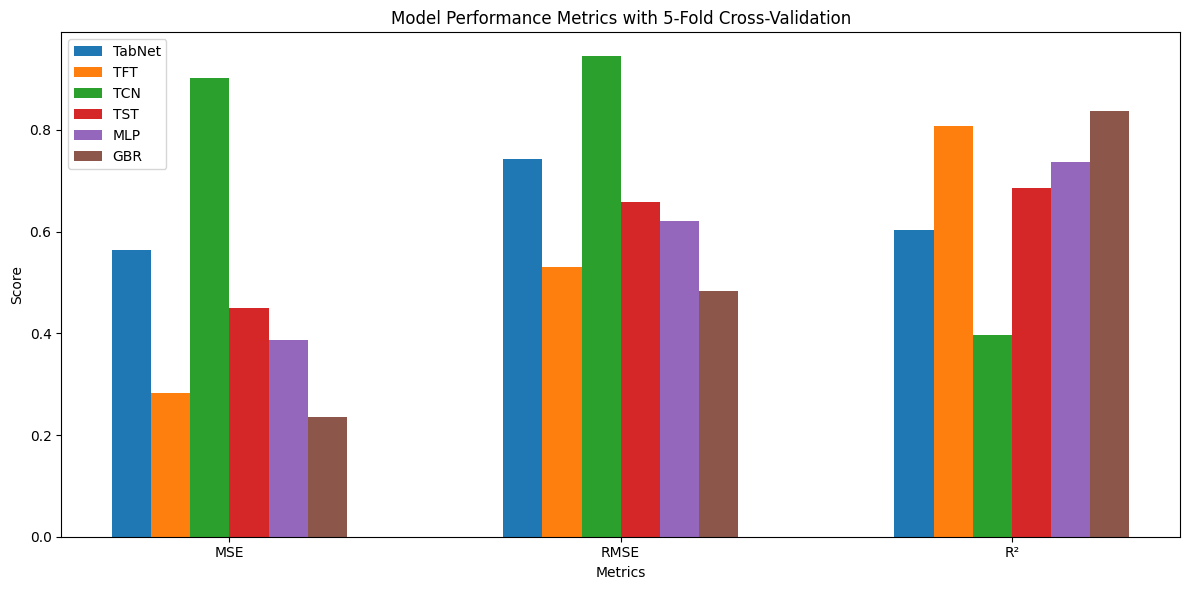

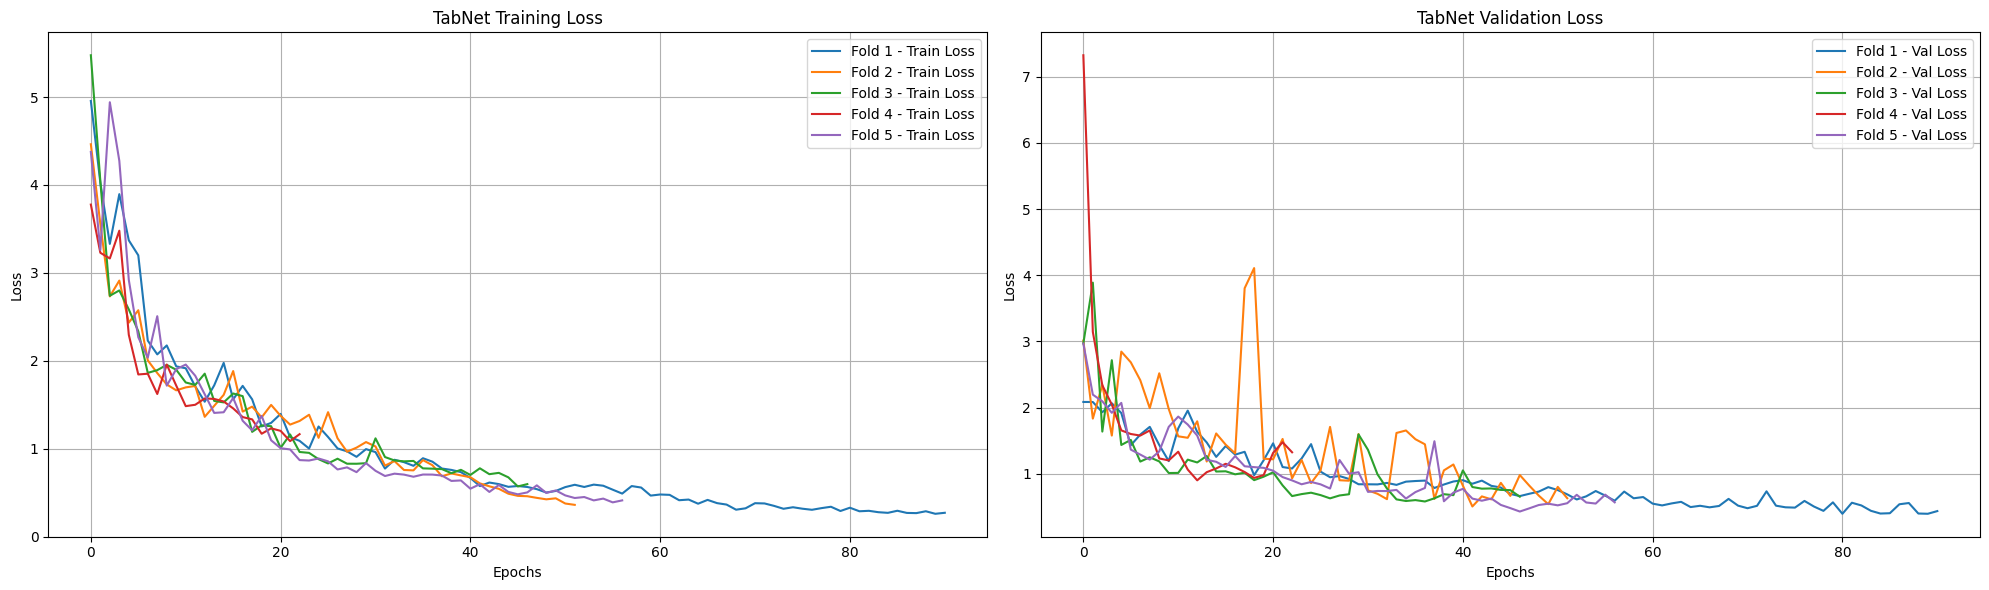

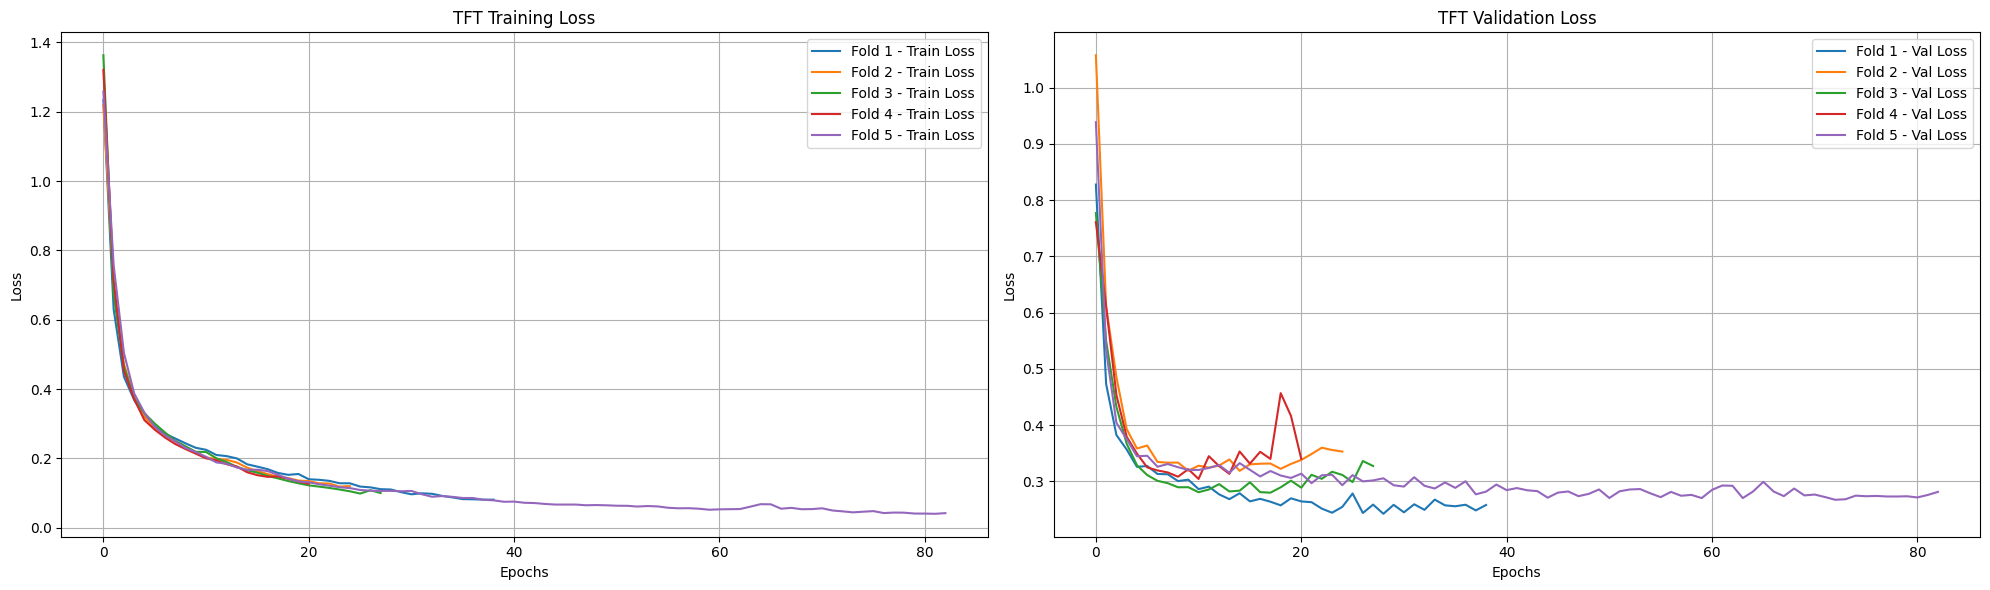

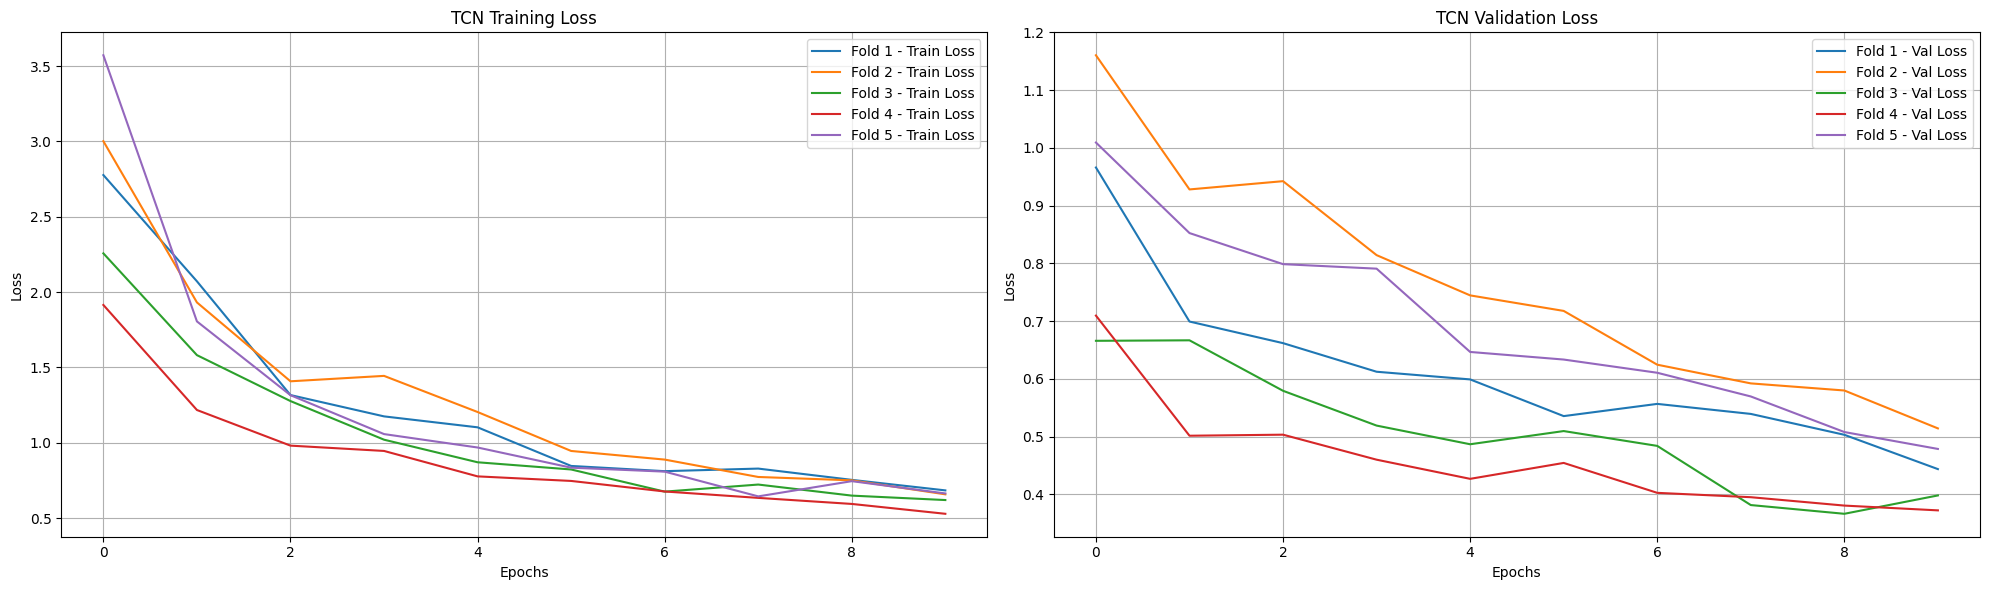

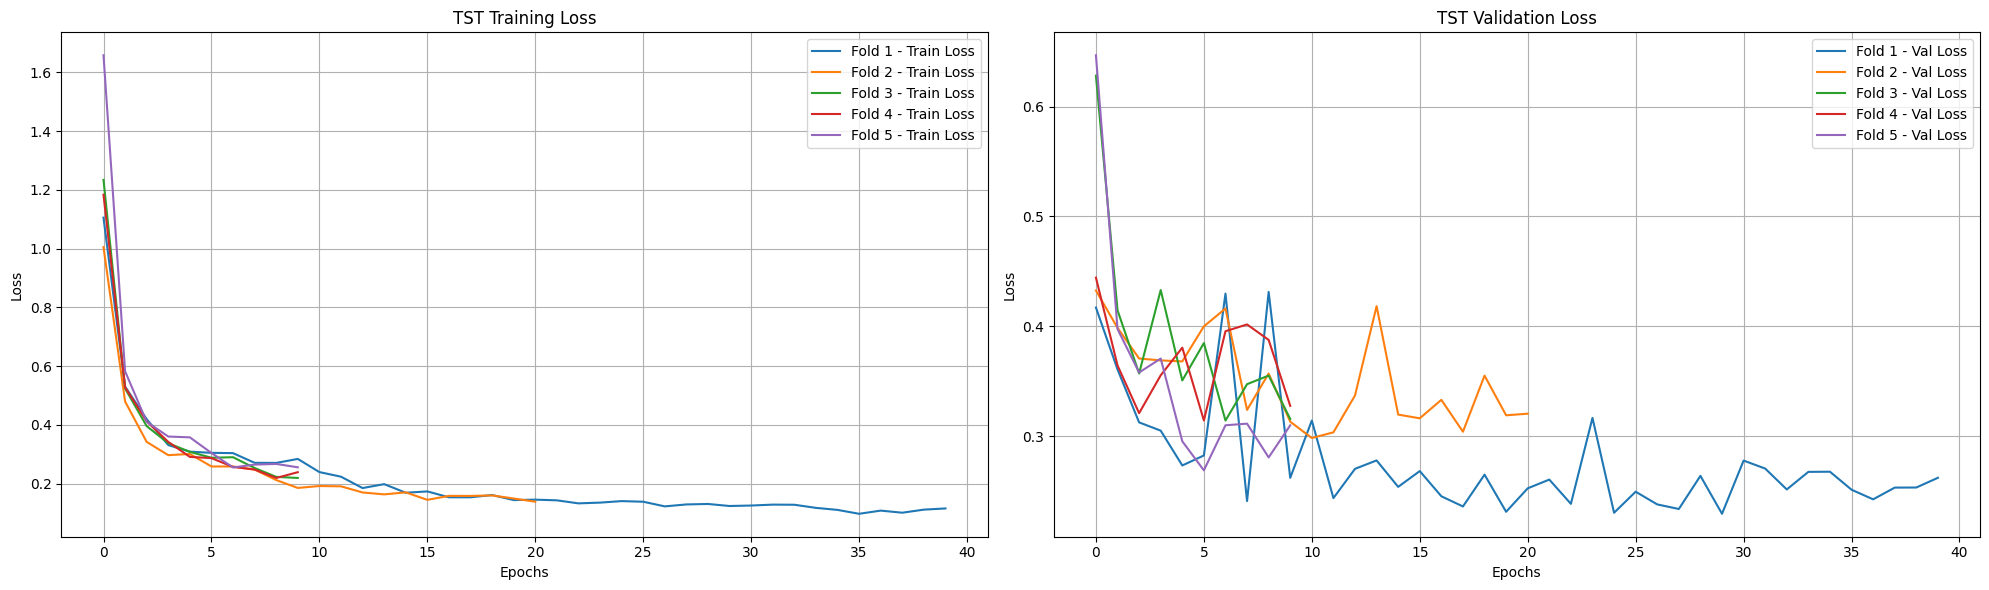

In [ ]:
# Print average results across all folds
for model_name in ['TabNet', 'TFT', 'TCN', 'TST', 'MLP', 'GBR']:
    mse_scores = [results[fold][model_name][0] for fold in results]
    rmse_scores = [results[fold][model_name][1] for fold in results]
    r2_scores = [results[fold][model_name][2] for fold in results]

    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)

    print(f"{model_name} - Average MSE: {avg_mse}, Average RMSE: {avg_rmse}, Average R²: {avg_r2}")

# Calculate average results across all folds for plotting
avg_results = {
    'TabNet': [
        np.mean([results[fold]['TabNet'][0] for fold in results]),
        np.mean([results[fold]['TabNet'][1] for fold in results]),
        np.mean([results[fold]['TabNet'][2] for fold in results])
    ],
    'TFT': [
        np.mean([results[fold]['TFT'][0] for fold in results]),
        np.mean([results[fold]['TFT'][1] for fold in results]),
        np.mean([results[fold]['TFT'][2] for fold in results])
    ],
    'TCN': [
        np.mean([results[fold]['TCN'][0] for fold in results]),
        np.mean([results[fold]['TCN'][1] for fold in results]),
        np.mean([results[fold]['TCN'][2] for fold in results])
    ],
    'TST': [
        np.mean([results[fold]['TST'][0] for fold in results]),
        np.mean([results[fold]['TST'][1] for fold in results]),
        np.mean([results[fold]['TST'][2] for fold in results])
    ],
    'MLP': [
        np.mean([results[fold]['MLP'][0] for fold in results]),
        np.mean([results[fold]['MLP'][1] for fold in results]),
        np.mean([results[fold]['MLP'][2] for fold in results])
    ],
    'GBR': [
        np.mean([results[fold]['GBR'][0] for fold in results]),
        np.mean([results[fold]['GBR'][1] for fold in results]),
        np.mean([results[fold]['GBR'][2] for fold in results])
    ]
}

# Plotting the performance metrics comparison
models = ['TabNet', 'TFT', 'TCN', 'TST', 'MLP', 'GBR']
metrics = ['MSE', 'RMSE', 'R²']

avg_results_array = np.array([avg_results[model] for model in models])

x = np.arange(len(metrics))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 2.5*width, avg_results_array[0], width, label='TabNet')
rects2 = ax.bar(x - 1.5*width, avg_results_array[1], width, label='TFT')
rects3 = ax.bar(x - 0.5*width, avg_results_array[2], width, label='TCN')
rects4 = ax.bar(x + 0.5*width, avg_results_array[3], width, label='TST')
rects5 = ax.bar(x + 1.5*width, avg_results_array[4], width, label='MLP')
rects6 = ax.bar(x + 2.5*width, avg_results_array[5], width, label='GBR')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics with 5-Fold Cross-Validation')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()

# Plot learning curves
for model_name in ['TabNet', 'TFT', 'TCN', 'TST']:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

    # Plot Training Loss
    for fold in range(1, 6):
        if model_name == 'TabNet':
            axes[0].plot(learning_curves[f'TabNet_Fold_{fold}']['loss'], label=f'Fold {fold} - Train Loss')
        else:
            axes[0].plot(learning_curves[f'{model_name}_Fold_{fold}']['loss'], label=f'Fold {fold} - Train Loss')

    axes[0].set_title(f'{model_name} Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Loss
    for fold in range(1, 6):
        if model_name == 'TabNet':
            axes[1].plot(learning_curves[f'TabNet_Fold_{fold}']['val_mse'], label=f'Fold {fold} - Val Loss')
        else:
            axes[1].plot(learning_curves[f'{model_name}_Fold_{fold}']['val_loss'], label=f'Fold {fold} - Val Loss')

    axes[1].set_title(f'{model_name} Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()